In [1]:
import numpy as np 
from recoMRD import recoMRD
import matplotlib.pyplot as plt
from bart import bart

In [2]:
filename = './../example_data/meas_MID00040_FID03385_localizer3D_iPAT2x2integrated.mrd'
mrd = recoMRD(filename)

mrd.img = mrd.kspace_to_image(mrd.kspace['image_scan'])
img_sos = mrd.remove_oversampling(mrd.img)
img_sos = mrd.coil_combination(img_sos, method='sos')
print(mrd.img.shape)
print(img_sos.shape)

MRD file has more than one group. The last group will be imported.
Acceleration factor: 2 x 2
Existing scans: acs, noise, image_scan.


Filling image_scan: 100%|██████████| 1330/1330 [00:00<00:00, 5879.30it/s]


Reorder slice... Done.


Fourier transform: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]

Remove oversampling... Done.
(20, 384, 191, 28, 1, 1, 1, 1, 1, 1, 1)
(1, 192, 191, 28, 1, 1, 1, 1, 1, 1, 1)


(192, 191, 28)
(192, 191, 8)


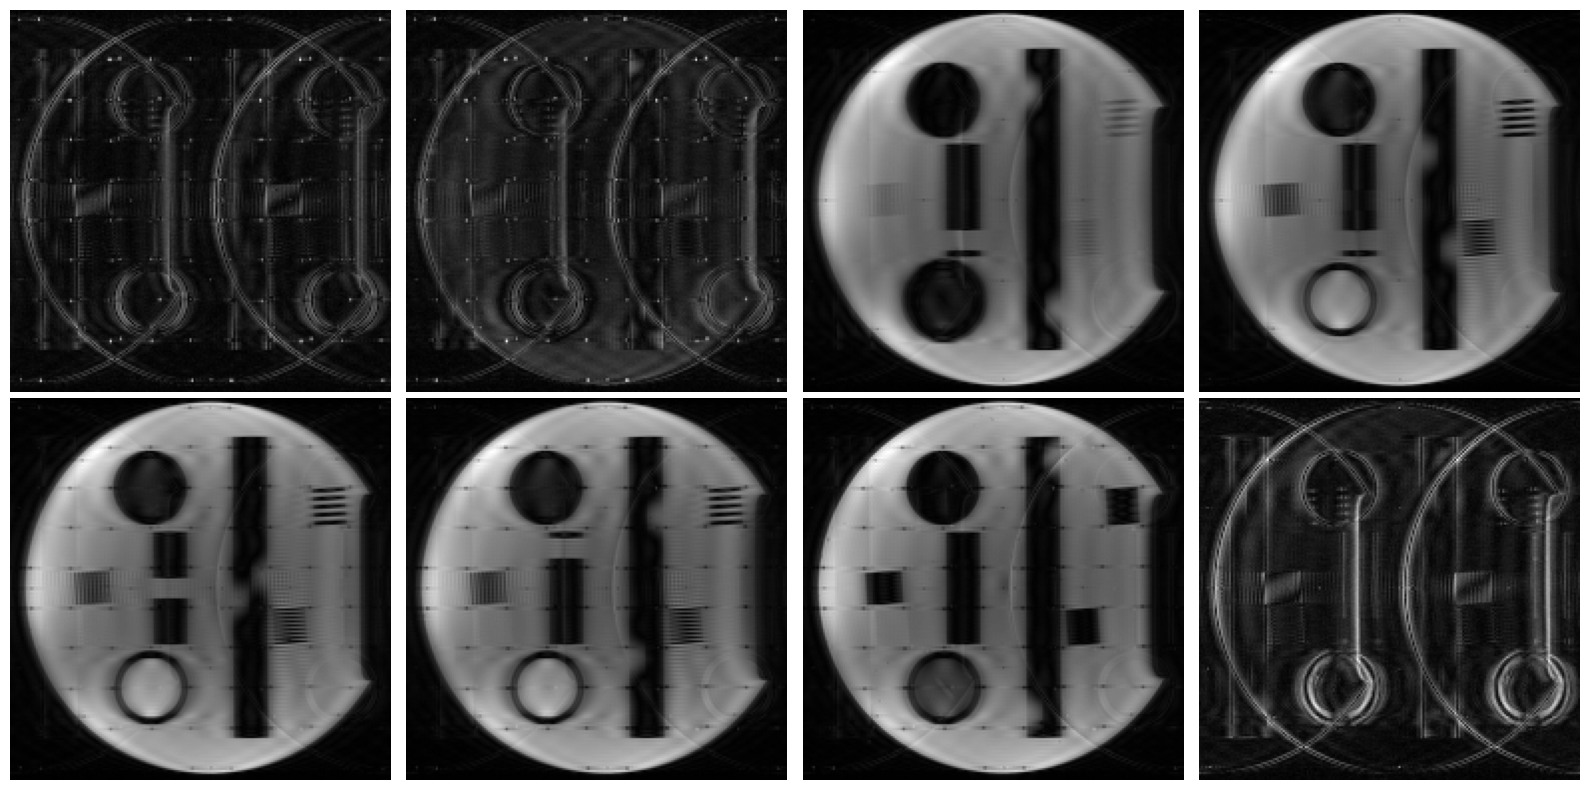

In [3]:
# sum of square reco
print(img_sos.squeeze().shape)
temp = img_sos.squeeze()[...,3:-3:3]
print(temp.shape)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[...,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout()  

(384, 191, 28)


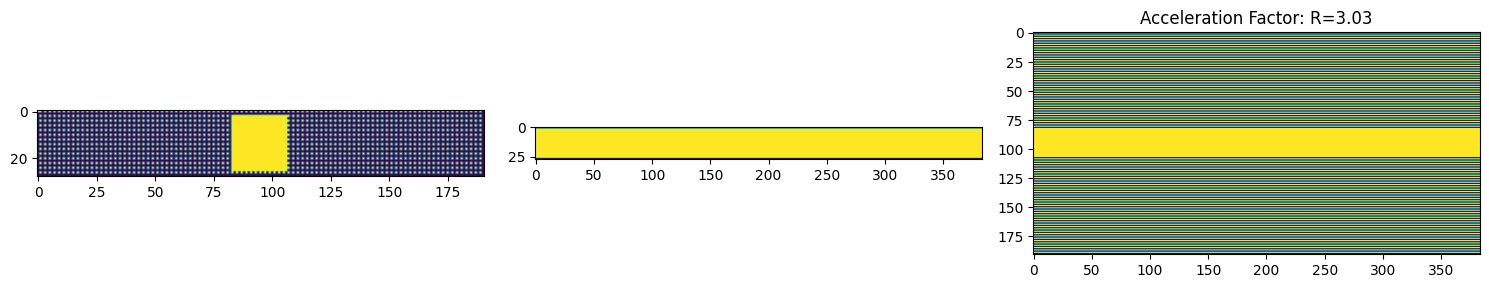

In [4]:
# show sampling pattern
temp = mrd.kspace['image_scan'].squeeze()[0,...]
mask = bart.bart(1, 'pattern', temp).real
print(mask.shape)
shp = [x // 2 for x in mask.shape]
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor
fig, axes = plt.subplots(1,3, figsize=(15, 5))
axes[0].imshow(np.abs(mask[shp[0],:,:]).T)
axes[1].imshow(np.abs(mask[:,shp[1],:]).T)
axes[2].imshow(np.abs(mask[:,:,shp[2]]).T)
plt.title('Acceleration Factor: R={:.2f}'.format(R))
plt.tight_layout()

(20, 384, 191, 28, 1, 1, 1, 1, 1, 1, 1)
(5, 384, 191, 28)


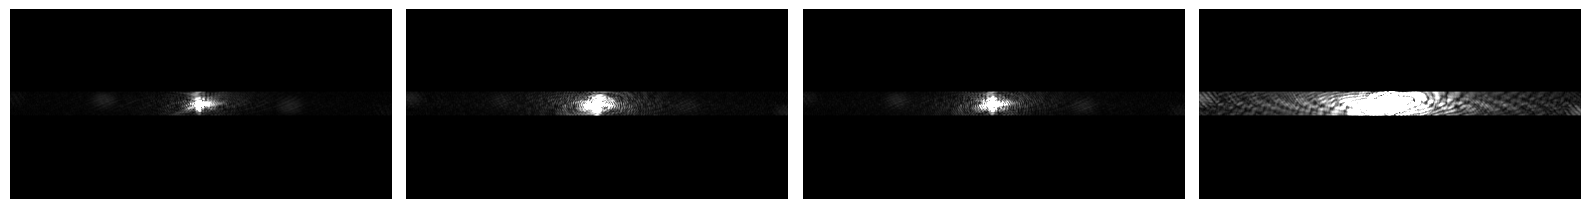

In [5]:
# show some Rx channels from reference scan
print(mrd.kspace['acs'].shape)
temp = mrd.kspace['acs'].squeeze()[::4,...]
print(temp.shape)
fig, axes = plt.subplots(1,4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(np.abs(temp[i,...,temp.shape[3]//2]).T,cmap='gray', vmax=1e-4)
    axes[i].set_axis_off()
plt.tight_layout() 

Fourier transform: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Remove oversampling... Done.
(192, 191, 8)


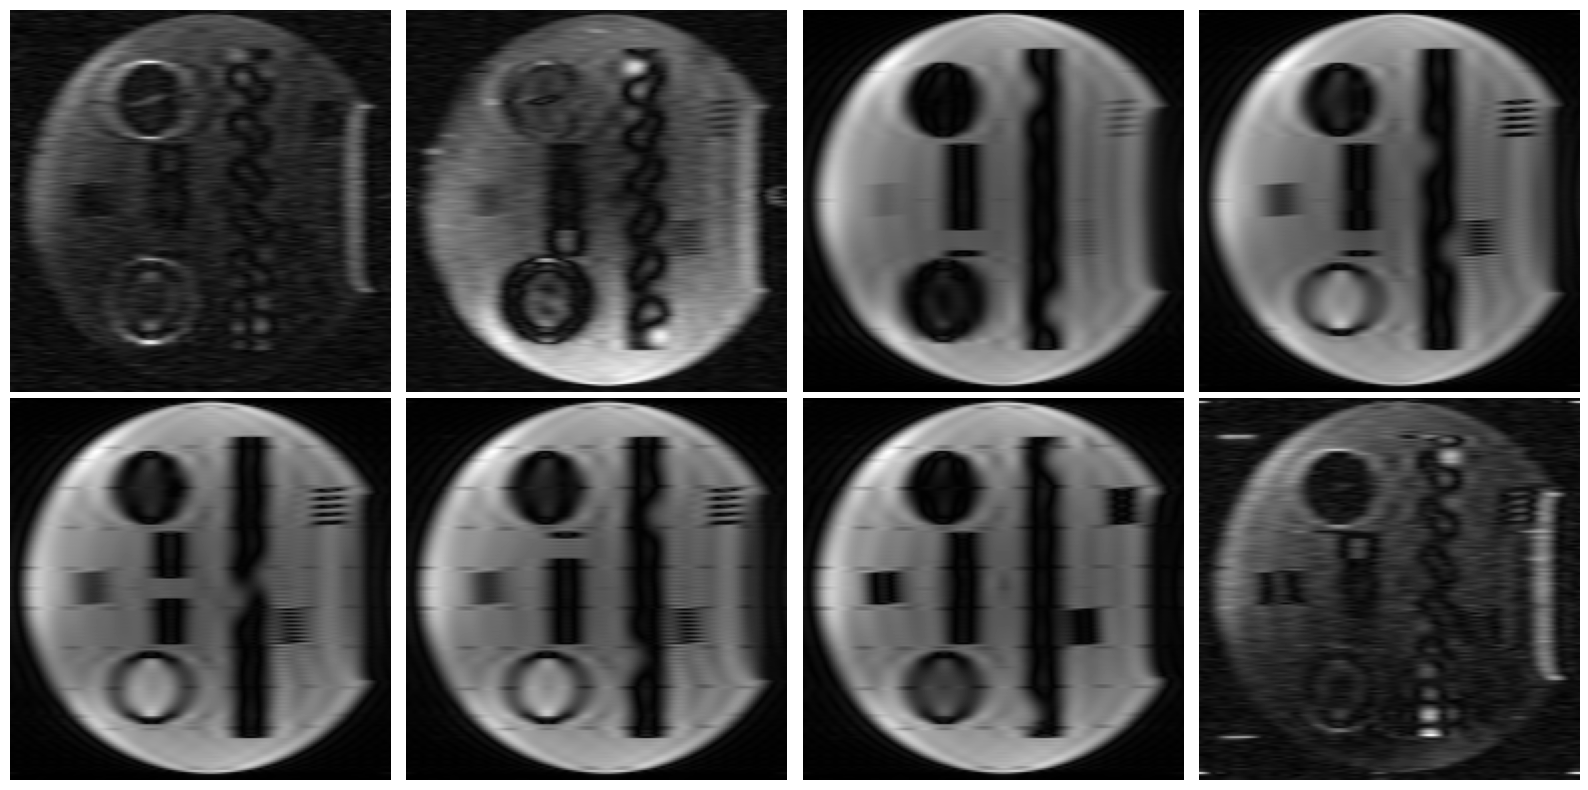

In [6]:
# sum of square of reference scan
acs_img = mrd.kspace_to_image(mrd.kspace['acs'])
acs_img = mrd.remove_oversampling(acs_img)
acs_img = mrd.coil_combination(acs_img, method='sos')

temp = acs_img.squeeze()[:,:,3:-3:3]
print(temp.shape)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[...,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 


In [7]:
%%time
# calculate coil sensitivity, using espirit method
coils_sensitivity = mrd.calc_coil_sensitivity(mrd.kspace['acs'], method='espirit')
print(coils_sensitivity.shape)

Done.
(20, 384, 191, 28, 1)
CPU times: user 491 ms, sys: 407 ms, total: 898 ms
Wall time: 35.7 s


In [8]:
%%time
# remove oversampling and calculate coil sensitivity, using espirit method
acs_img = mrd.kspace_to_image(mrd.kspace['acs'])
acs_img = mrd.remove_oversampling(acs_img)
acs_img = mrd.image_to_kspace(acs_img)
coils_sensitivity_os_removed = mrd.calc_coil_sensitivity(acs_img, method='espirit')
print(coils_sensitivity_os_removed.shape)

Fourier transform: 100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


Remove oversampling... Done.


Fourier transform: 100%|██████████| 20/20 [00:01<00:00, 17.63it/s]


Done.
(20, 192, 191, 28, 1)
CPU times: user 3.75 s, sys: 490 ms, total: 4.24 s
Wall time: 33.7 s


In [9]:
%%time
# calculate coil sensitivity, using caldir method
coils_sensitivity_caldir = mrd.calc_coil_sensitivity(mrd.kspace['acs'], method='caldir')


Input = (384, 191, 28, 20), Calibration size = 192
Calibration region 192x24x24
Done.
CPU times: user 464 ms, sys: 456 ms, total: 920 ms
Wall time: 12.2 s


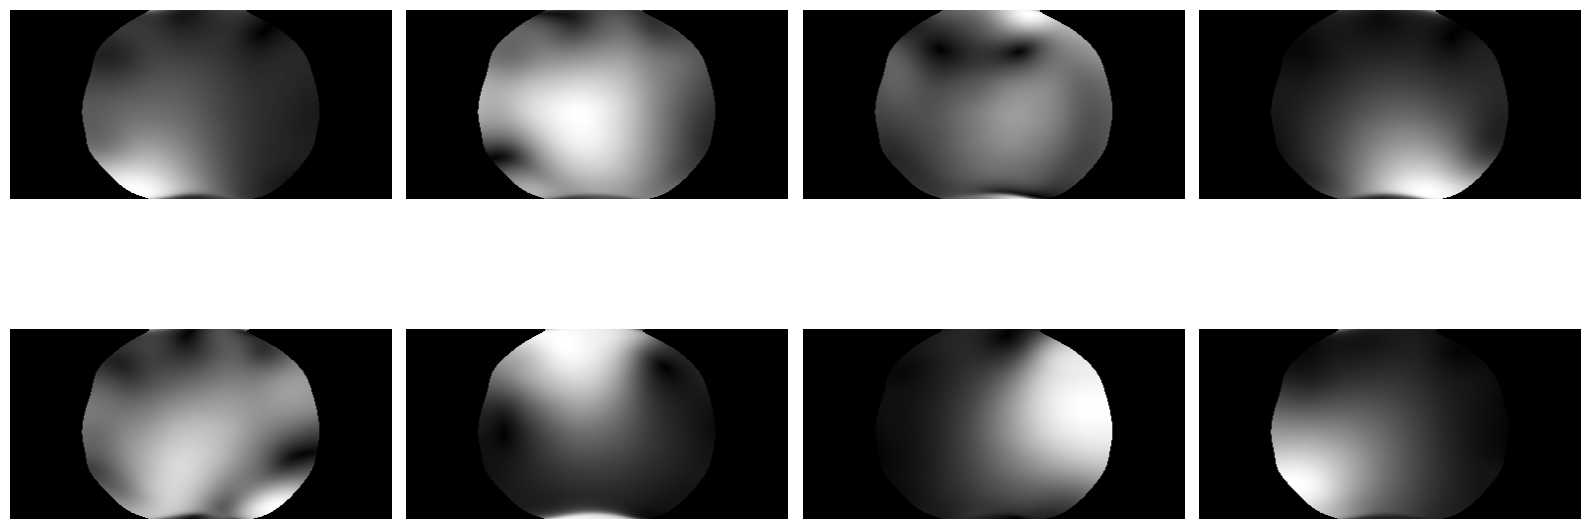

In [10]:
# display coil sensitivity
temp = coils_sensitivity[::2,...,14,0].squeeze()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[index+i*4,...].T),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 

Remove oversampling... Done.
(1, 192, 191, 28, 1, 1, 1, 1, 1, 1, 1)


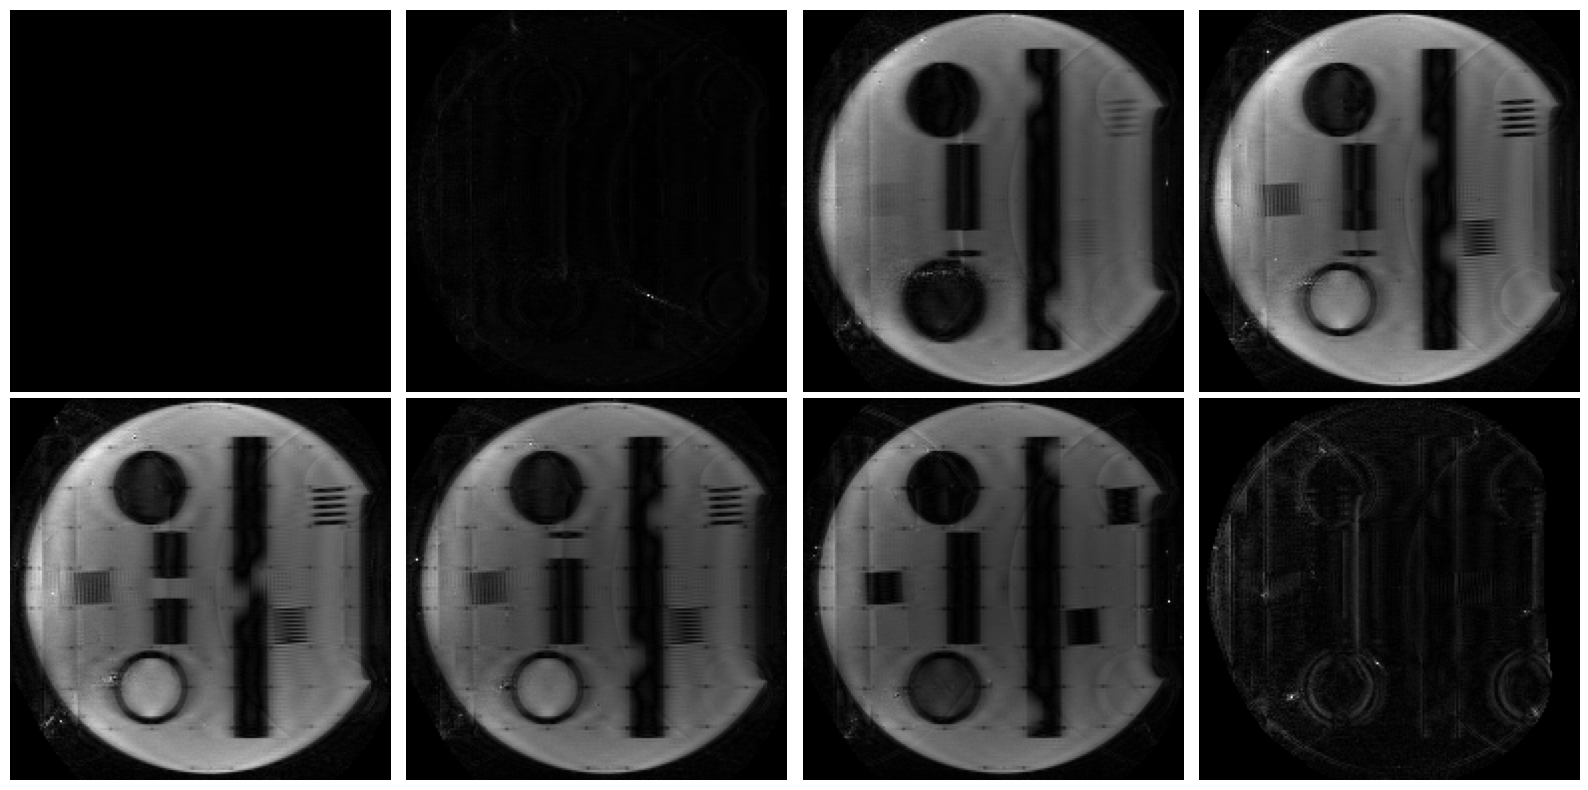

In [11]:
# reconstruct image with a simple coil combination
volume_comb = mrd.coil_combination(mrd.img, method='adaptive', coil_sens=coils_sensitivity)
volume_comb = mrd.remove_oversampling(volume_comb)
print(volume_comb.shape)

temp = volume_comb.squeeze()[...,3:-3:3]
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[:,:,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 

In [14]:
%%time
# reconstruct image with bart
volume_comb = mrd.coil_combination(mrd.kspace['image_scan'], method='bart', coil_sens=coils_sensitivity)
print(volume_comb.shape)

Size: 2053632 Samples: 676991 Acc: 3.03
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 12.359488
(1, 384, 191, 28, 1, 1, 1, 1, 1, 1, 1)
CPU times: user 584 ms, sys: 534 ms, total: 1.12 s
Wall time: 13.5 s


Remove oversampling... Done.


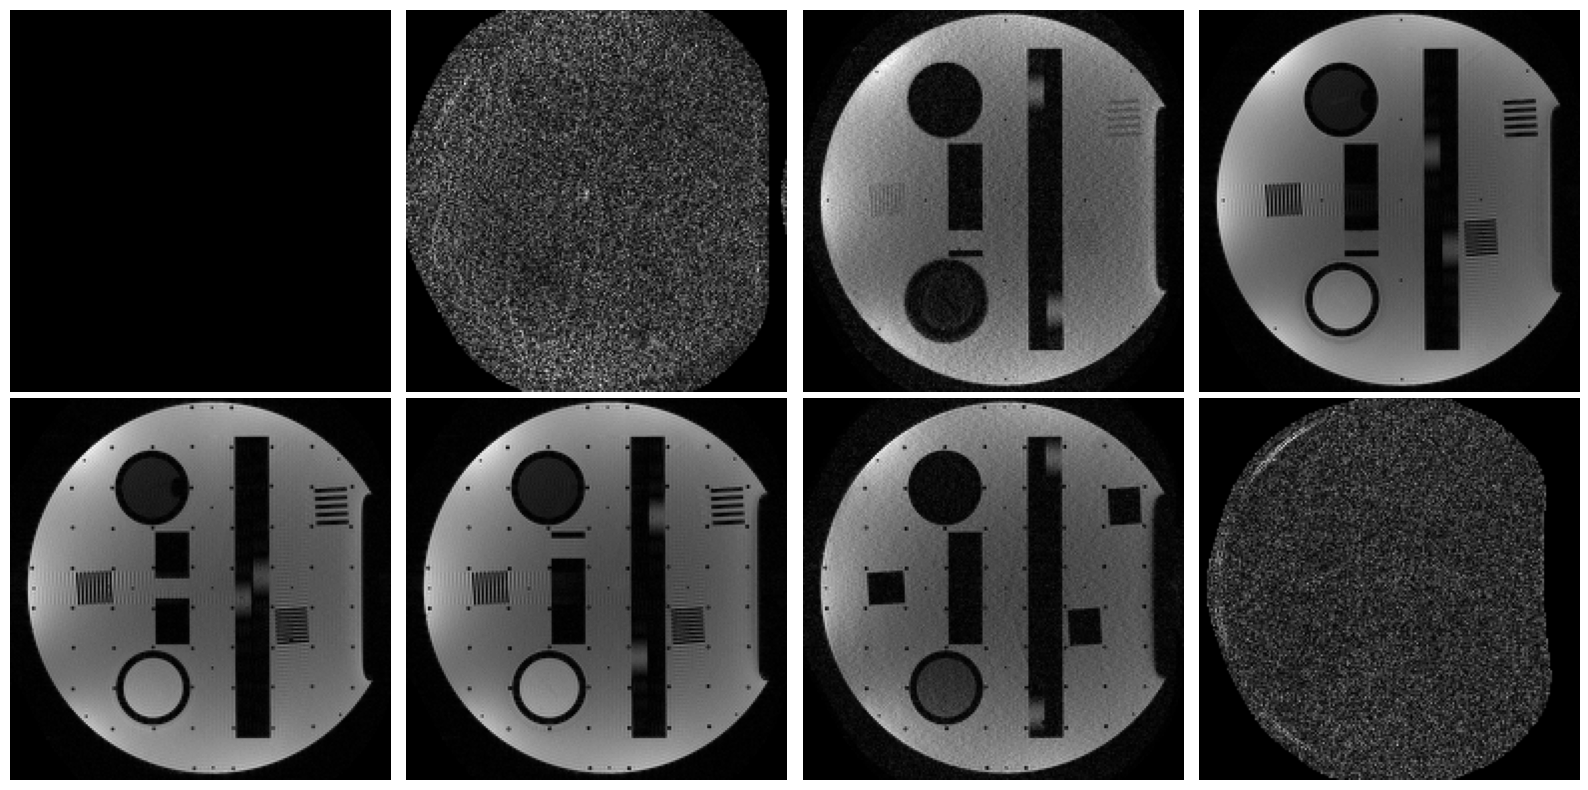

In [15]:
# display reconstructed image with bart
volume_comb = mrd.remove_oversampling(volume_comb)
temp = volume_comb.squeeze()[...,3:-3:3]
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[:,:,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 